In [1]:
import numpy as np
import readtrc, lecroy
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit

In [2]:
def read_file(filename):
    y, metadata = readtrc.read_trc_file(filename)
    y_uV = readtrc.convert_to_uV(y,metadata)
    x_time = set_time_axis(y_uV,metadata)
    return x_time, y_uV, metadata

def set_time_axis(y_uV,metadata):
    x_time = np.linspace(0,y_uV.size,y_uV.size)
    if (metadata['INSTRUMENT_NAME']=='LECROYSDA5000'):
        x_time*0.1 #czas w ns
    else:
        x_time*0.4
    return x_time

def read_more_files(filenames):
    l = [ ]
    for e in filenames:
        l.append( read_file(e) )
    return l

def convert_to_mV(x):
    return x*1e-3

def simple_plot(x,y,xlab,ylab, log = 0, col='b'):
    plt.plot(x,y, color=col)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if (log):
        plt.yscale("log")
        plt.ylim(bottom=1e-8)
    plt.grid(color='y', linestyle=':', linewidth=0.5)
    plt.show()
    
def two_simple_plots(x1,y1,x2,y2,xlab,ylab,log = 0):
    plt.plot(x1,y1,'b-', label ='dane')
    plt.plot(x2,y2,'r-', label = 'dopasowanie')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if (log):
        plt.yscale("log")
        plt.ylim(bottom=1e-8,top=1)
    plt.grid(color='y', linestyle=':', linewidth=0.5)
    plt.legend()
    plt.show()
    
def create_histogram(y):
    xlab = "voltage [mV]"
    ylab = "counts"
    n = int(np.ptp(y)/2000)
    weights = np.ones_like(y)/float(len(y))
    
    ydata, x = np.histogram(y, n, weights=weights)
    xdata=[]
    for i in range(0,len(x)-1):
        xdata.append( x[i] + 0.5*(x[i+1]-x[i]) )
    return convert_to_mV(np.array(xdata)), np.array(ydata)

def mean_val(y):
    return np.mean(y)

def std_dev(y):
    return np.std(y)

def gaussian(x, amp, mi, var):
    return amp * np.exp(-(x-mi)**2 / (2*var**2))

In [3]:
data = read_more_files(["77MeV/C2Trace00000.trc", "450000/C1diamond10000000.trc", "450000/C1diamond10000002.trc"])


In [4]:
m_std=[]

for e in data:
    print("Mean:", convert_to_mV(mean_val(e[1])), " [mV]")
    print("Standard deviation: ", convert_to_mV(std_dev(e[1])), " [mV]")
    m_std.append( np.array([convert_to_mV(mean_val(e[1])),convert_to_mV(std_dev(e[1]))]) )
    print("")
    
m_std=np.array(m_std)
print(m_std)

('Mean:', 0.5566112693672445, ' [mV]')
('Standard deviation: ', 13.001102774172615, ' [mV]')

('Mean:', -0.5592441749662815, ' [mV]')
('Standard deviation: ', 4.456375052497157, ' [mV]')

('Mean:', -0.5187394469403493, ' [mV]')
('Standard deviation: ', 4.539238434315655, ' [mV]')

[[ 0.55661127 13.00110277]
 [-0.55924417  4.45637505]
 [-0.51873945  4.53923843]]


In [44]:
hist = []
for e in data:
    hist.append( create_histogram(e[1])) #xdata, ydata
    #simple_plot( hist[-1][0], hist[-1][1], "voltage [mV]", "counts",1)
    #simple_plot(e[0][:20000],e[1][:20000], "time [us]", "voltage [uV]")
    #print(hist[-1][0][:100],hist[-1][1][:100])

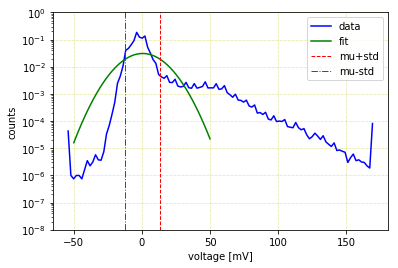

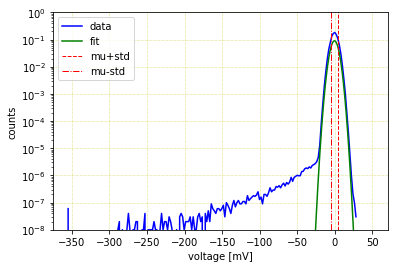

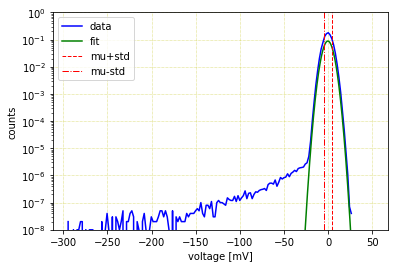

In [6]:
# Simple gaussian fit

x = np.linspace(-50,50,1000)

simple_gauss=[]
for e in m_std:
    amp = 1/math.sqrt(2*math.pi*e[1]**2)
    simple_gauss.append( gaussian(x, amp, e[0], e[1] ))
    
for i in range(0,3):
    plt.plot(hist[i][0],hist[i][1],'b-',label='data')
    plt.plot(x,simple_gauss[i],'g-', label = 'fit')
    plt.axvline(x=m_std[i][0]+m_std[i][1],color='r',label='mu+std',linestyle='--',linewidth=1.0)
    plt.axvline(x=m_std[i][0]-m_std[i][1],color='r',label='mu-std',linestyle='-.',linewidth=1.0)
    plt.xlabel('voltage [mV]')
    plt.ylabel('counts')
    plt.yscale('log')
    plt.ylim(bottom=1e-8,top=1)
    plt.grid(color='y', linestyle=':', linewidth=0.5)
    plt.legend()
    plt.show()

[ 0.03068526  0.55661127 13.00110277]
[ 0.0895217  -0.55924417  4.45637505]
[ 0.08788749 -0.51873945  4.53923843]


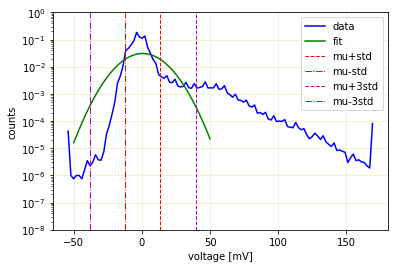

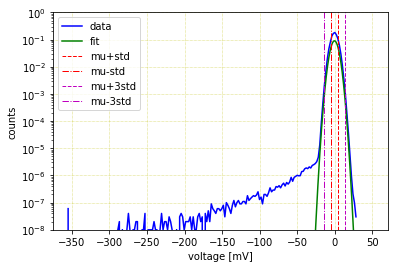

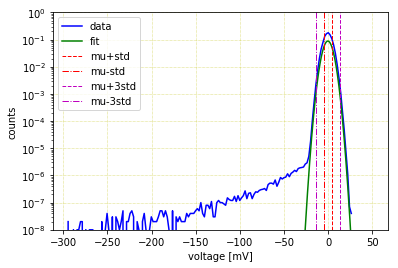

In [7]:
from scipy.optimize import curve_fit

sp_gauss=[]
sp_mstd=[]

for e in m_std:
    amp = 1/math.sqrt(2*math.pi*e[1]**2)
    y = gaussian(x, amp, e[0], e[1])
    best_vals, covar = curve_fit(gaussian,x,y)
    sp_mstd.append( best_vals )
    print(best_vals)#amplituda, średnia, wariancja * 2
    sp_gauss.append( gaussian(x, best_vals[0], best_vals[1], best_vals[2]) )
    
    
for i in range(0,3):
    plt.plot(hist[i][0],hist[i][1],'b-',label='data')
    plt.plot(x,sp_gauss[i],'g-', label = 'fit')
    plt.axvline(x=sp_mstd[i][1]+sp_mstd[i][2],color='r',label='mu+std',linestyle='--',linewidth=1.0)
    plt.axvline(x=sp_mstd[i][1]-sp_mstd[i][2],color='r',label='mu-std',linestyle='-.',linewidth=1.0)
    plt.axvline(x=sp_mstd[i][1]+3*sp_mstd[i][2],color='m',label='mu+3std',linestyle='--',linewidth=1.0)
    plt.axvline(x=sp_mstd[i][1]-3*sp_mstd[i][2],color='m',label='mu-3std',linestyle='-.',linewidth=1.0)
    plt.xlabel('voltage [mV]')
    plt.ylabel('counts')
    plt.yscale('log')
    plt.ylim(bottom=1e-8,top=1)
    plt.grid(color='y', linestyle=':', linewidth=0.5)
    plt.legend()
    plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 112
    # variables        = 3
    chi-square         = 0.00545435
    reduced chi-square = 5.0040e-05
    Akaike info crit   = -1106.14214
    Bayesian info crit = -1097.98665
[[Variables]]
    amp:  0.14557370 +/- 0.00409253 (2.81%) (init = 0.03068526)
    mi:  -2.13686363 +/- 0.16520480 (7.73%) (init = 0.5566113)
    var:  5.08840992 +/- 0.16520481 (3.25%) (init = 13.0011)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, var) = -0.577



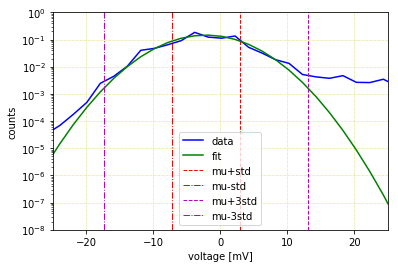

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 192
    # variables        = 3
    chi-square         = 4.5557e-05
    reduced chi-square = 2.4104e-07
    Akaike info crit   = -2922.77442
    Bayesian info crit = -2913.00194
[[Variables]]
    amp:  0.17940212 +/- 3.0325e-04 (0.17%) (init = 0.0895217)
    mi:  -0.56194955 +/- 0.00867734 (1.54%) (init = -0.5592442)
    var:  4.44572754 +/- 0.00867734 (0.20%) (init = 4.456375)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, var) = -0.577



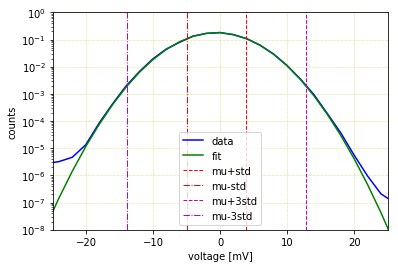

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 161
    # variables        = 3
    chi-square         = 4.5369e-05
    reduced chi-square = 2.8714e-07
    Akaike info crit   = -2422.21666
    Bayesian info crit = -2412.97245
[[Variables]]
    amp:  0.17599896 +/- 3.2781e-04 (0.19%) (init = 0.08788749)
    mi:  -0.49220091 +/- 0.00973907 (1.98%) (init = -0.5187394)
    var:  4.52826348 +/- 0.00973907 (0.22%) (init = 4.539238)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, var) = -0.577



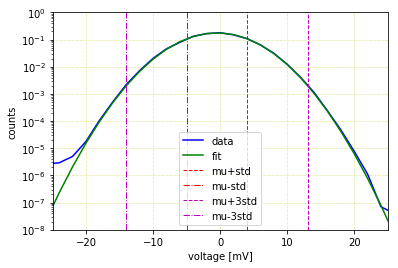

In [50]:
from lmfit import Model

lm_gauss=[]
lm_mstd=[]
for i in range(0,3):
    amp = 1/math.sqrt(2*math.pi*m_std[i][1]**2)
    gmodel = Model(gaussian)
    result = gmodel.fit(hist[i][1],x=hist[i][0],amp=amp,mi=m_std[i][0],var=m_std[i][1])
    print( result.fit_report())
    lm_gauss.append( result.best_fit )
    lm_mstd.append( result.best_values )
    plt.plot(hist[i][0],hist[i][1],'b-',label='data')
    plt.plot(hist[i][0],result.best_fit,'g-', label = 'fit')
    plt.axvline(x=result.best_values['mi']+result.best_values['var'],color='r',label='mu+std',linestyle='--',linewidth=1.0)
    plt.axvline(x=result.best_values['mi']-result.best_values['var'],color='r',label='mu-std',linestyle='-.',linewidth=1.0)
    plt.axvline(x=result.best_values['mi']+3*result.best_values['var'],color='m',label='mu+3std',linestyle='--',linewidth=1.0)
    plt.axvline(x=result.best_values['mi']-3*result.best_values['var'],color='m',label='mu-3std',linestyle='-.',linewidth=1.0)
    plt.xlabel('voltage [mV]')
    plt.ylabel('counts')
    plt.yscale('log')
    plt.ylim(bottom=1e-8,top=1)
    plt.xlim(-25,25)
    plt.grid(color='y', linestyle=':', linewidth=0.5)
    plt.legend()
    plt.show()

In [42]:
# gaussian fit on noisy region

#sp_mstd = [amp, mi, var]
noise=[]
noise_mstd=[]
noise_hist=[]
for i in range(0,3):
    mask1 = data[i][0] < (sp_mstd[i][1]+sp_mstd[i][2]*1e3)
    mask2 = data[i][0] > (sp_mstd[i][1]-sp_mstd[i][2]*1e3)
    mask = np.logical_and(mask1, mask2)
    noise.append( [ data[i][0][mask], data[i][1][mask] ])
    #simple_plot(noise[-1][0][:20000],noise[-1][1][:20000], "time [us]", "voltage [uV]")
    noise_mstd.append( [ convert_to_mV(mean_val(noise[-1][1])), convert_to_mV(std_dev(noise[-1][1])) ] )
    print(noise_mstd[-1])
    print(m_std[i])
    noise_hist.append( create_histogram(data[i][1])) #xdata, ydata

[0.5102205814490078, 14.823729411775581]
[ 0.55661127 13.00110277]
[-0.4305655296229803, 4.3575307029777175]
[-0.55924417  4.45637505]
[-0.4408900638907248, 4.351201255891938]
[-0.51873945  4.53923843]


[ 0.02691241  0.51022058 14.82372941]
[ 0.09155237 -0.43056553  4.3575307 ]
[ 0.09168555 -0.44089006  4.35120126]


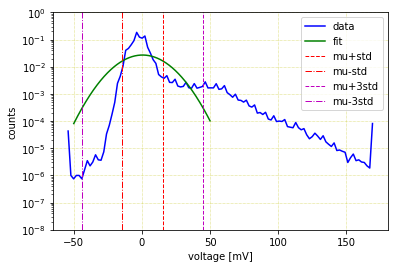

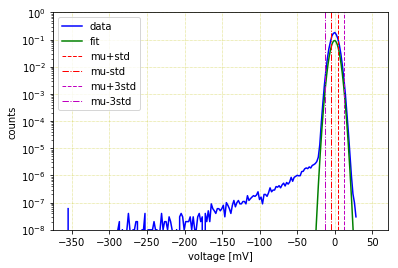

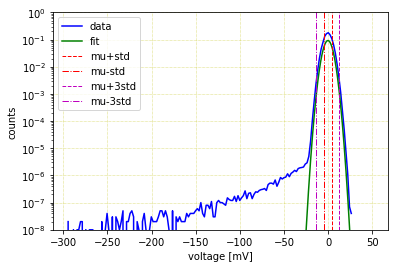

In [38]:
from scipy.optimize import curve_fit

spn_gauss=[]
spn_mstd=[]

for e in noise_mstd:
    amp = 1/math.sqrt(2*math.pi*e[1]**2)
    y = gaussian(x, amp, e[0], e[1])
    best_vals, covar = curve_fit(gaussian,x,y)
    spn_mstd.append( best_vals )
    print(best_vals)#amplituda, średnia, wariancja * 2
    spn_gauss.append( gaussian(x, best_vals[0], best_vals[1], best_vals[2]) )
    
    
for i in range(0,3):
    plt.plot(hist[i][0],hist[i][1],'b-',label='data')
    plt.plot(x,spn_gauss[i],'g-', label = 'fit')
    plt.axvline(x=spn_mstd[i][1]+spn_mstd[i][2],color='r',label='mu+std',linestyle='--',linewidth=1.0)
    plt.axvline(x=spn_mstd[i][1]-spn_mstd[i][2],color='r',label='mu-std',linestyle='-.',linewidth=1.0)
    plt.axvline(x=spn_mstd[i][1]+3*spn_mstd[i][2],color='m',label='mu+3std',linestyle='--',linewidth=1.0)
    plt.axvline(x=spn_mstd[i][1]-3*spn_mstd[i][2],color='m',label='mu-3std',linestyle='-.',linewidth=1.0)
    plt.xlabel('voltage [mV]')
    plt.ylabel('counts')
    plt.yscale('log')
    plt.ylim(bottom=1e-8,top=1)
    plt.grid(color='y', linestyle=':', linewidth=0.5)
    plt.legend()
    plt.show()
    
#nadal paskudne dopasowanie dla danych z 2017

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 112
    # variables        = 3
    chi-square         = 0.00545435
    reduced chi-square = 5.0040e-05
    Akaike info crit   = -1106.14214
    Bayesian info crit = -1097.98665
[[Variables]]
    amp:  0.14557422 +/- 0.00409270 (2.81%) (init = 0.02691241)
    mi:  -2.13685394 +/- 0.16519075 (7.73%) (init = 0.5102206)
    var: -5.08837363 +/- 0.16519075 (3.25%) (init = 14.82373)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, var) =  0.577



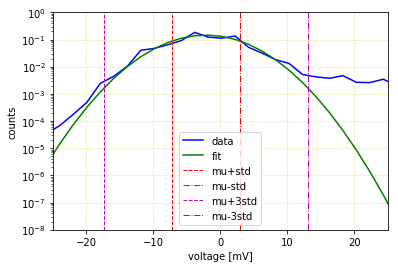

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 192
    # variables        = 3
    chi-square         = 4.5557e-05
    reduced chi-square = 2.4104e-07
    Akaike info crit   = -2922.77442
    Bayesian info crit = -2913.00194
[[Variables]]
    amp:  0.17940212 +/- 3.0325e-04 (0.17%) (init = 0.09155237)
    mi:  -0.56194955 +/- 0.00867734 (1.54%) (init = -0.4305655)
    var:  4.44572761 +/- 0.00867734 (0.20%) (init = 4.357531)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, var) = -0.577



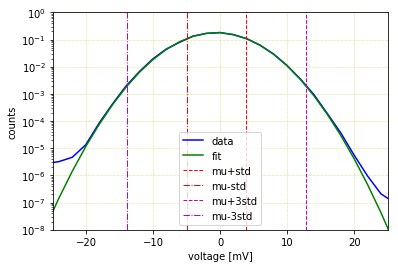

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 161
    # variables        = 3
    chi-square         = 4.5369e-05
    reduced chi-square = 2.8714e-07
    Akaike info crit   = -2422.21666
    Bayesian info crit = -2412.97245
[[Variables]]
    amp:  0.17599896 +/- 3.2781e-04 (0.19%) (init = 0.09168555)
    mi:  -0.49220091 +/- 0.00973908 (1.98%) (init = -0.4408901)
    var:  4.52826351 +/- 0.00973908 (0.22%) (init = 4.351201)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, var) = -0.577



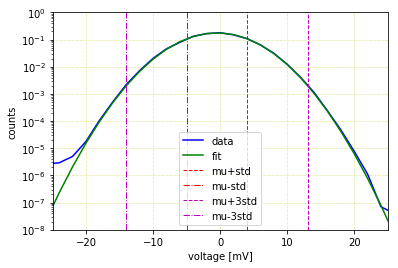

In [49]:
from lmfit import Model

nlm_gauss=[]
nlm_mstd=[]
for i in range(0,3):
    amp = 1/math.sqrt(2*math.pi*noise_mstd[i][1]**2)
    gmodel = Model(gaussian)
    result = gmodel.fit(noise_hist[i][1],x=noise_hist[i][0],amp=amp,mi=noise_mstd[i][0],var=noise_mstd[i][1])
    print( result.fit_report())
    nlm_gauss.append( result.best_fit )
    nlm_mstd.append( result.best_values )
    plt.plot(hist[i][0],hist[i][1],'b-',label='data')
    plt.plot(noise_hist[i][0],result.best_fit,'g-', label = 'fit')
    plt.axvline(x=result.best_values['mi']+result.best_values['var'],color='r',label='mu+std',linestyle='--',linewidth=1.0)
    plt.axvline(x=result.best_values['mi']-result.best_values['var'],color='r',label='mu-std',linestyle='-.',linewidth=1.0)
    plt.axvline(x=result.best_values['mi']+3*result.best_values['var'],color='m',label='mu+3std',linestyle='--',linewidth=1.0)
    plt.axvline(x=result.best_values['mi']-3*result.best_values['var'],color='m',label='mu-3std',linestyle='-.',linewidth=1.0)
    plt.xlabel('voltage [mV]')
    plt.ylabel('counts')
    plt.yscale('log')
    plt.ylim(bottom=1e-8,top=1)
    plt.xlim(-25,25)
    plt.grid(color='y', linestyle=':', linewidth=0.5)
    plt.legend()
    plt.show()